In [2]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
#pull the data
df = pd.read_csv('financial_data_cleaned.csv')

In [4]:

#Encoding Sentiment variable
Encoder = LabelEncoder() 
df["Sentiment"] = Encoder.fit_transform(df["Sentiment"])  
df["Sentiment"].value_counts()

Sentiment
1    3130
2    1852
0     860
Name: count, dtype: int64

In [5]:
#Term Frequency - Inverse Document Frequency (TF-IDF) Vectorizer
tfidf = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))
X = tfidf.fit_transform(df["Sentence"])
X.shape

(5842, 5000)

In [6]:
y = df['Sentiment']
y

0       2
1       0
2       2
3       1
4       1
       ..
5837    0
5838    1
5839    1
5840    1
5841    2
Name: Sentiment, Length: 5842, dtype: int64

In [7]:
#Balance the imbalanced dataset
Counter(y)

Counter({1: 3130, 2: 1852, 0: 860})

In [8]:
Balancer = SMOTE(random_state = 42)
X_final, y_final = Balancer.fit_resample(X, y)

/Users/mayankmalhotra/Developer/internship_project2/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [9]:
Counter(y_final)

Counter({2: 3130, 0: 3130, 1: 3130})

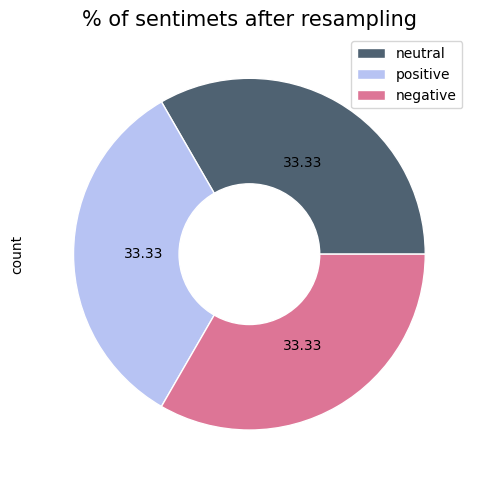

In [10]:
#Pie chart
colors = ['#4F6272', '#B7C3F3', '#DD7596']
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 5))
y_final.value_counts().head(3).plot(kind='pie', labels=None, autopct='%.2f', ax=ax1, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors).legend(labels={
                     "neutral":"1",
                     "positive":"2",
                     "negative":"0"})
central_circle = plt.Circle((0, 0), 0.4, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title('% of sentimets after resampling', size=15)
plt.tight_layout()
plt.savefig('images/donut_chart_balanced_data.png', dpi=300)
plt.show()

In [11]:
#Model Selection
#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.20, random_state = 42)

In [12]:
#Model building
dt = DecisionTreeClassifier()
lr = LogisticRegression()
SVC = SVC()
rf = RandomForestClassifier()
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

Models = [dt, lr, SVC, rf, Bayes, KNN]
Models_Dict = {0: "Decision Tree", 1: "Logistic Regression", 2: "SVC", 3: "Random Forest", 4: "Naive Bayes", 5: "K-Neighbors"}

for i, model in enumerate(Models):
  print("{} Test Accuracy: {}".format(Models_Dict[i], cross_val_score(model, X, y, cv = 10, scoring = "accuracy").mean()))

Decision Tree Test Accuracy: 0.531153260742302
Logistic Regression Test Accuracy: 0.6264968973188152
SVC Test Accuracy: 0.5890109471958787
Random Forest Test Accuracy: 0.5626460601803067
Naive Bayes Test Accuracy: 0.5997986184287554
K-Neighbors Test Accuracy: 0.5181310736447723


In [13]:
#Hyperparamater Tuning
import warnings
warnings.filterwarnings("ignore")
Param = {"C": np.logspace(-4, 4, 50), "penalty": ['l1', 'l2']}
grid_search = GridSearchCV(estimator = LogisticRegression(random_state = 42), param_grid = Param, scoring = "accuracy", cv = 10, verbose = 0, n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

/Users/mayankmalhotra/Developer/internship_project2/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mayankmalhotra/Developer/internship_project2/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

Best Accuracy: 65.16 %
Best Parameters: {'C': np.float64(1048.1131341546852), 'penalty': 'l2'}


In [14]:
#Best model
Classifier = LogisticRegression(random_state = 42, C = 6866.488450042998, penalty = 'l2')
Classifier.fit(X_train, y_train)

Prediction = Classifier.predict(X_test)

In [15]:
#Metrics
accuracy_score(y_test, Prediction)

0.663471778487753

In [16]:
#Confusion Matrix
ConfusionMatrix = confusion_matrix(y_test, Prediction)


In [17]:
# Plotting Function for Confusion Matrix
colors = ['#4F6272', '#B7C3F3', '#DD7596']

def plot_cm(cm, classes, title, normalized = False, cmap = plt.cm.BuPu):
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title, pad = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    

    if normalized:
        cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Unnormalized Confusion Matrix")
  
    threshold = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.xlabel("Predicted Label", labelpad = 20)
    plt.ylabel("Real Label", labelpad = 20)

Unnormalized Confusion Matrix


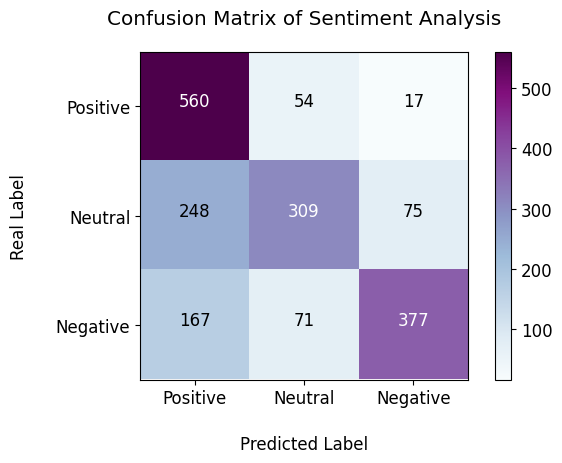

In [18]:
plot_cm(ConfusionMatrix, classes = ["Positive", "Neutral", "Negative"], title = "Confusion Matrix of Sentiment Analysis")
plt.tight_layout()
plt.savefig('images/confusion_matrix.png', dpi=300)

print(classification_report(y_test, Prediction))


In [19]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, Prediction, target_names=["Positive", "Neutral", "Negative"])

# Print the report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

    Positive       0.57      0.89      0.70       631
     Neutral       0.71      0.49      0.58       632
    Negative       0.80      0.61      0.70       615

    accuracy                           0.66      1878
   macro avg       0.70      0.66      0.66      1878
weighted avg       0.70      0.66      0.66      1878

